<a href="https://colab.research.google.com/github/chaos44/CGAN/blob/master/concatenated4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.compat.v1.keras.layers import BatchNormalization

from keras.datasets import mnist
from keras.layers import (Activation, Concatenate, Dense,
                          Embedding, Flatten, Input, Multiply, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [3]:
img_rows = 28
img_cols = 28
channels = 1

#   入力画像の次元
img_shape = (img_rows, img_cols, channels)

# 生成器の入力として用いるノイズベクトルのサイズ
z_dim = 100

# データセットに含まれるクラスの数
num_classes = 10

In [5]:
# Generator
def build_generator(z_dim):

    model = Sequential()

    # 入力を、全結合層を通じて7 * 7 * 256のテンソルに変形する
    ## Denseは入力をテンソルに変えることもできる、第一層だけ、input_dimを指定する必要がある。(input_dimもテンソル指定できるのか、普通はベクトル単位だと思うが)
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    ## Reshapeの意味？
    model.add(Reshape((7, 7, 256))) 

    # 転置畳み込み層 from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

In [6]:
def build_cgan_generator(z_dim):

    # Random noise vector z
    z = Input(shape=(z_dim, ))
    print('num_classes')
    print(num_classes)
    print()
    # Conditioning label: integer 0-9 specifying the number G should generate
    label = Input(shape=(1, ), dtype='int32')
    print('z:')
    print(z)
    print()
    # Label embedding:
    # ----------------
    # ラベルをz_dimサイズの密のベクトルに変換する。
    # 形状(batch_size, 1, z_dim)の3Dテンソルを作成する
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
    print('3D:')
    print(label_embedding)
    print()
    # 3Dテンソルを2Dテンソルに平坦化 (batch_size, z_dim)
    label_embedding = Flatten()(label_embedding)
    print('2D:')
    print(label_embedding)
    print()
    # ノイズz(1, z_dim)? と (batch_size, z_dim)要素ごとの積を取る（ラベルの特徴を持つノイズ） 
    joined_representation = Multiply()([z, label_embedding])
    # print(joined_representation)
    generator = build_generator(z_dim)

    # 与えられたラベルの画像を生成する
    conditioned_img = generator(joined_representation)
    # [z, label]も返す意味は？
    return Model([z, label], conditioned_img)

In [8]:
'''
(X_train, y_train), (_, _) = mnist.load_data()

# Rescale [0, 255] grayscale pixel values to [-1, 1]
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)
# idx = np.random.randint(0, X_train.shape[0], batch_size)
idx = 0
imgs, labels = X_train[idx], y_train[idx]

print('idx:')
print(idx)
print()
print('imgs:')
print(imgs)
print()
print('labels:')
print(labels)
print()

batch_size = 32
generator = build_cgan_generator(z_dim)
z = np.random.normal(0, 1, (batch_size, z_dim))
gen_imgs = generator.predict([z, labels])
print(gen_imgs)
'''

"\n(X_train, y_train), (_, _) = mnist.load_data()\n\n# Rescale [0, 255] grayscale pixel values to [-1, 1]\nX_train = X_train / 127.5 - 1.\nX_train = np.expand_dims(X_train, axis=3)\n# idx = np.random.randint(0, X_train.shape[0], batch_size)\nidx = 0\nimgs, labels = X_train[idx], y_train[idx]\n\nprint('idx:')\nprint(idx)\nprint()\nprint('imgs:')\nprint(imgs)\nprint()\nprint('labels:')\nprint(labels)\nprint()\n\nbatch_size = 32\ngenerator = build_cgan_generator(z_dim)\nz = np.random.normal(0, 1, (batch_size, z_dim))\ngen_imgs = generator.predict([z, labels])\nprint(gen_imgs)\n"

In [14]:
# Discriminator
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x2 into 14x14x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               # input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
               # input_shape=(img_shape[0], img_shape[1], img_shape[2]),
               input_shape=(img_shape[0], img_shape[1], img_shape[2] + 3),
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x64 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [15]:
# 実験コード
# 識別器の複合表現 (画像 + ラベル + 画像 + ラベル) 28 * 28 * 4 

In [16]:
def build_cgan_discriminator(img_shape):
    print(num_classes)
    # Input image
    img = Input(shape=img_shape)

    # Label for the input image
    label = Input(shape=(1, ), dtype='int32')

    # Label embedding:
    # ----------------
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape (batch_size, 1, 28*28*1)
    label_embedding = Embedding(num_classes,
                                np.prod(img_shape),
                                input_length=1)(label)
  
    # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, 28*28*1)
    label_embedding = Flatten()(label_embedding)
    print(label_embedding)
    # Reshape label embeddings to have same dimensions as input images
    label_embedding = Reshape(img_shape)(label_embedding)
    print(label_embedding)
    print(img)
    # Concatenate images with their label embeddings
    # concatenated = Concatenate(axis=-1)([img, label_embedding])
    # concatenated = Multiply()([img, label_embedding]) # Multiply()使うとshapeは(None, 28, 28, 1)でエラー、(None, 28, 28, 2)だと正しい
    # 疑問：なぜconcatenatedは(None, 28, 28, 2)のshapeを持たないといけない？
    concatenated_tmp = Concatenate(axis=-1)([img, label_embedding])
    concatenated = Concatenate(axis=-1)([concatenated_tmp, concatenated_tmp])
    print('concatenated:')
    print(concatenated)
    print()
    discriminator = build_discriminator(img_shape)

    # Classify the image-label pair
    classification = discriminator(concatenated)
    # classificationは与えられた
    return Model([img, label], classification)

In [17]:
# Build the Model
def build_cgan(generator, discriminator):

    # Random noise vector z
    z = Input(shape=(z_dim, ))

    # Image label
    label = Input(shape=(1, ))

    # Generated image for that label
    img = generator([z, label])

    classification = discriminator([img, label])

    # Combined Generator -> Discriminator model
    # G([z, lablel]) = x*
    # D(x*) = classification
    model = Model([z, label], classification)

    return model

In [18]:
# Build and compile the Discriminator
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_cgan_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile CGAN model with fixed Discriminator to train the Generator
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

10
Tensor("flatten_3/Reshape:0", shape=(None, 784), dtype=float32)
Tensor("reshape_2/Reshape:0", shape=(None, 28, 28, 1), dtype=float32)
Tensor("input_5:0", shape=(None, 28, 28, 1), dtype=float32)
concatenated:
Tensor("concatenate_3/concat:0", shape=(None, 28, 28, 4), dtype=float32)

num_classes
10

z:
Tensor("input_7:0", shape=(None, 100), dtype=float32)

3D:
Tensor("embedding_3/embedding_lookup/Identity_1:0", shape=(None, 1, 100), dtype=float32)

2D:
Tensor("flatten_5/Reshape:0", shape=(None, 100), dtype=float32)



In [19]:
# Training
accuracies = []
losses = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, y_train), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images and their labels
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])

        # Train the Discriminator
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of noise vectors
        z = np.random.normal(0, 1, (batch_size, z_dim))

        # Get a batch of random labels
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # Train the Generator
        g_loss = cgan.train_on_batch([z, labels], real)

        if (iteration + 1) % sample_interval == 0:

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            # Output sample of generated images
            sample_images()

In [20]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    labels = np.arange(0, 10).reshape(-1, 1)

    # Generate images from random noise
    gen_imgs = generator.predict([z, labels])

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

1000 [D loss: 0.013554, acc.: 100.00%] [G loss: 6.967834]
2000 [D loss: 0.000185, acc.: 100.00%] [G loss: 7.071786]
3000 [D loss: 0.002182, acc.: 100.00%] [G loss: 8.163645]
4000 [D loss: 0.242638, acc.: 92.19%] [G loss: 2.984759]
5000 [D loss: 0.029289, acc.: 100.00%] [G loss: 2.988212]
6000 [D loss: 0.157091, acc.: 93.75%] [G loss: 3.286968]
7000 [D loss: 0.148128, acc.: 96.88%] [G loss: 3.323370]
8000 [D loss: 0.899099, acc.: 59.38%] [G loss: 3.339885]
9000 [D loss: 0.088714, acc.: 98.44%] [G loss: 4.128892]
10000 [D loss: 0.044397, acc.: 100.00%] [G loss: 3.057223]
11000 [D loss: 0.032025, acc.: 100.00%] [G loss: 6.483176]
12000 [D loss: 0.042762, acc.: 100.00%] [G loss: 3.400414]


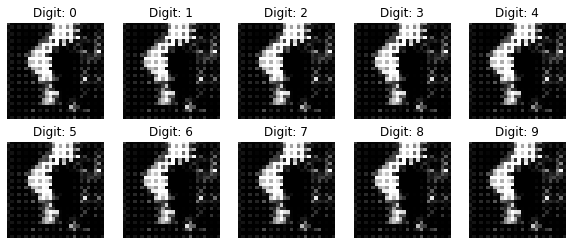

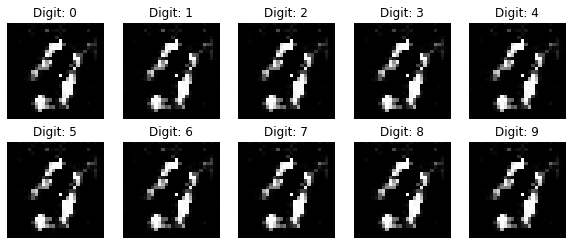

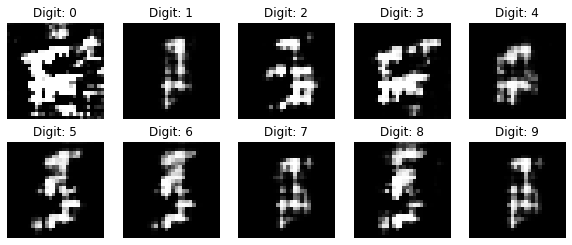

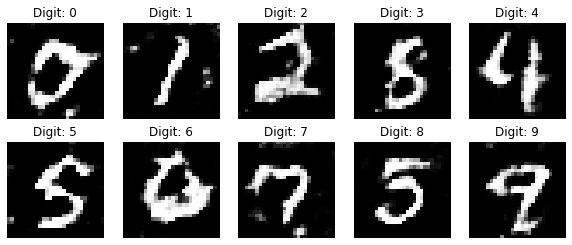

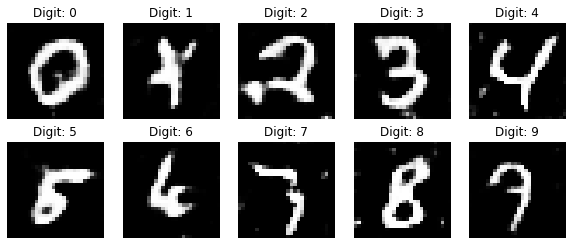

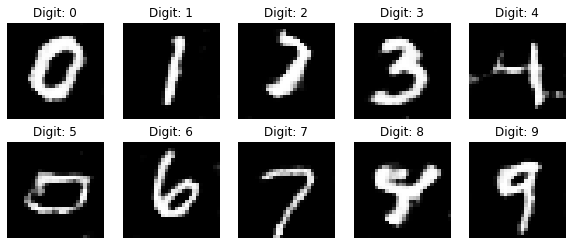

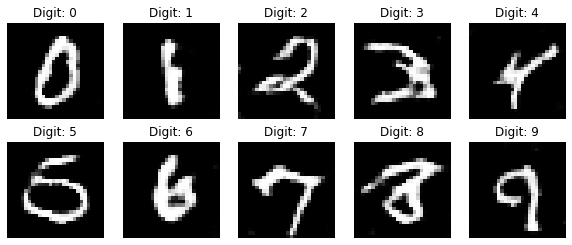

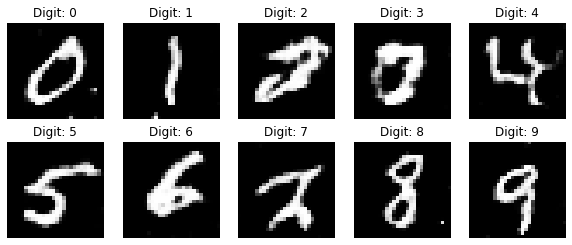

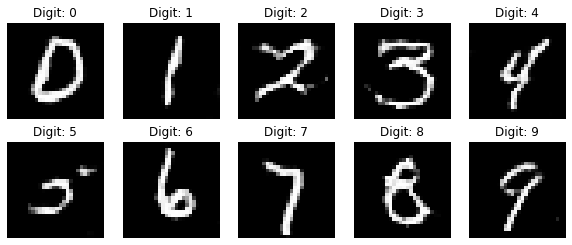

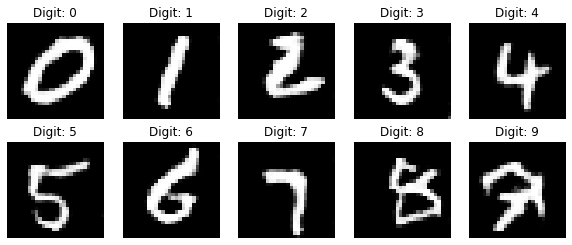

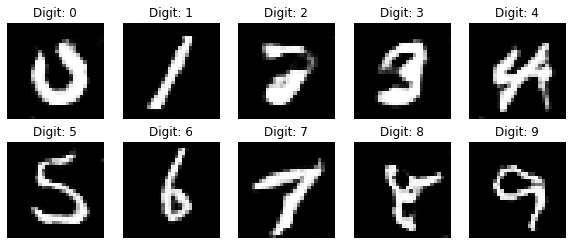

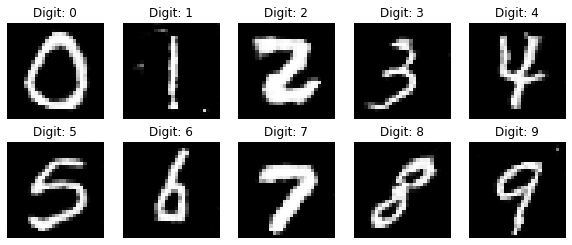

In [21]:
# Train the Model and Inspect Training Progres
# Note that the 'Discrepancy between trainable weights and collected trainable' warning from Keras is expected. 
# It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

# Set hyperparameters
iterations = 12000
batch_size = 32
sample_interval = 1000

# Train the CGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)